In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision

import PIL
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import os
import re

from tqdm.auto import tqdm

In [2]:
import pandas as pd

In [3]:
from fold_actions import *

In [4]:
f_path = "data/fold/"

In [5]:
IMAGE_SIZE = 28

In [6]:
USE_CUDA = True

In [7]:
class ClothImages(Dataset):
    def __init__(self, folder_path,  transforms=None, revert=False):
        self.revert = revert
        self.data_root_folder = folder_path
        self.image_list, self.action_list  = self.load_image_list(self.data_root_folder)
        self.transforms = transforms
        
    def load_image_list(self, folder_path):
        image_list = []
        action_list = None
        for dress_folder in os.listdir(folder_path):
            if dress_folder.endswith(".csv"):
                action_list = pd.read_csv(folder_path + dress_folder)
            else:
                dress_image_list = []
                image_folder = os.path.join(folder_path, dress_folder)
                order_image_list = os.listdir(image_folder)
                if self.revert:
                    order_image_list = order_image_list[::-1]
                for file_name in order_image_list:
                    #image_list.append(os.path.join(image_folder, file_name))
                    single_image_path = os.path.join(image_folder, file_name)
                    dress_image_list.append(single_image_path)

                image_list.append(dress_image_list)
        
        return image_list, action_list
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        img_list = [] 
        for dress_image_path in self.image_list[index]:
            #print(dress_image_path)
            # Open image
            img = PIL.Image.open(dress_image_path).convert("L")
            img = PIL.ImageOps.invert(img)
            #img = resize(img,(IMAGE_SIZE,IMAGE_SIZE))
            if self.transforms is not None:
                img = self.transforms(img)
            
            img_list.append(img)
            
        if self.transforms is None:
            return img_list
        
        img_tensor = torch.stack(img_list,dim=0)
        return img_tensor
        

In [8]:
# transforms = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((IMAGE_SIZE,IMAGE_SIZE), interpolation= PIL.Image.NEAREST),
#     torchvision.transforms.RandomAffine(degrees = 90, translate = (0.2,0.2), scale = (0.6,1)),
#     #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
#     torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.RandomVerticalFlip(),
#     # torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
#     torchvision.transforms.ToTensor(),
# ])

In [9]:
ci = ClothImages(f_path, revert=False)

In [10]:
def conv3x3(in_channels, out_channels, **kwargs):
    # The convolutional layers (for feature extraction) use standard layers from
    # `torch.nn`, since they do not require adaptation.
    # See `examples/maml/model.py` for comparison.
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, **kwargs),
        nn.BatchNorm2d(out_channels, momentum=1., track_running_stats=False),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

In [11]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, in_channels, out_features, hidden_size=64):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = hidden_size

        self.features = nn.Sequential(
            conv3x3(in_channels, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size)
        )

        self.linear_aesthetics = nn.Sequential(
            nn.Linear(hidden_size, out_features),
            nn.Sigmoid(),
        )

    def forward(self, inputs, params=None):
        features = self.features(inputs)
        #print(features.shape)
        features = features.view((features.size(0), -1))
        #print(features.shape)
        scores = self.linear_aesthetics(features)
        return scores

In [ ]:
model = ConvolutionalNeuralNetwork(1, 1, hidden_size=64)

In [ ]:
if USE_CUDA and torch.cuda.is_available():
    model = model.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
transforms_after = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMAGE_SIZE,IMAGE_SIZE),interpolation = PIL.Image.NEAREST),
    torchvision.transforms.RandomAffine(degrees = 90, translate = (0.2,0.2), scale = (0.6,1)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor(),
])


# Train

In [ ]:
def calculate_image_score(cloth_img: np.array, transform_img, model_img, use_cuda = False):
    img = Image.fromarray(np.uint8(cloth_img * 255), 'L')
    img_t = transform_img(img)
    if use_cuda:
        img_t = img_t.to("cuda")
    img_t_score = model_img(img_t.unsqueeze(0))
    
    return img_t_score

In [ ]:
epochs = 100

In [ ]:
for epoch in range(epochs):
    loss_epoch = []
    for i in tqdm(range(len(ci.image_list))):
        for j in range(len(ci.image_list[i]) - 1):
            oriImage = read_cloth_image(ci.image_list[i][j], show_image=False)
            nextImage = read_cloth_image(ci.image_list[i][j + 1], show_image=False)

            curA, curS, curImage = fold_action_max(oriImage, model, transforms_after, use_cuda=USE_CUDA)

            loss = - calculate_image_score(nextImage, transforms_after, model, USE_CUDA) \
                    + calculate_image_score(curImage, transforms_after, model, USE_CUDA)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_epoch.append(loss.item())
            
            #print(loss.item())
    print(np.mean(loss_epoch))

In [ ]:
torch.save(model, "record/fold_me_irl.pth")

In [ ]:
# img0 = read_cloth_image(ci.image_list[0][0])
# img1 = read_cloth_image(ci.image_list[0][1])

# oriImage = img0

# curA, curS, curImage = fold_action_max(oriImage, model, transforms_after)

# # calculate_image_score(img1, transforms_after, model)

# # calculate_image_score(curImage, transforms_after, model)

# loss = - calculate_image_score(img1, transforms_after, model) + calculate_image_score(curImage, transforms_after, model)

# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

In [ ]:
model2 = ConvolutionalNeuralNetwork(1, 1, hidden_size=64)

In [ ]:
pretrained_dict = torch.load("10_27.pth")

model2_dict = model2.state_dict()
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model2_dict}
# 2. overwrite entries in the existing state dict
model2_dict.update(pretrained_dict) 
# 3. load the new state dict
model2.load_state_dict(model2_dict)

if torch.cuda.is_available():
    model2 = model2.cuda()

optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)


In [ ]:
for epoch in tqdm(range(epochs)):
    loss_epoch = []
    for i in range(len(ci.image_list)):
        for j in range(len(ci.image_list[i]) - 1):
            oriImage = read_cloth_image(ci.image_list[i][j], show_image=False)
            nextImage = read_cloth_image(ci.image_list[i][j + 1], show_image=False)

            curA, curS, curImage = fold_action_max(oriImage, model2, transforms_after, use_cuda=USE_CUDA)

            loss = - calculate_image_score(nextImage, transforms_after, model2, USE_CUDA) \
                    + calculate_image_score(curImage, transforms_after, model2, USE_CUDA)

            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()
            
            loss_epoch.append(loss.item())
            
            #print(loss.item())
    print(np.mean(loss_epoch))

In [ ]:
torch.save(model2, "record/fold_me_irl_pre.pth")

# Test 

In [44]:
model = torch.load("record/fold_gail.pth")
model2 = torch.load("record/fold_gail_pre.pth")

In [45]:
model.eval()
model2.eval()

ConvolutionalNeuralNetwork(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, 

In [46]:
model = model.cpu()
model2 = model2.cpu()

In [16]:
transforms_test= torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMAGE_SIZE,IMAGE_SIZE),interpolation = PIL.Image.NEAREST),
    torchvision.transforms.RandomAffine(degrees = 0, translate = (0.0,0.0), scale = (0.8,0.8)),
    torchvision.transforms.ToTensor(),
])

In [ ]:
cloth_folder = "C:\\Users\\Yizhou Zhao\\Desktop\\AI\\validation\\"

In [ ]:
os.listdir(cloth_folder)

In [ ]:
for file_name in os.listdir(cloth_folder):
    if file_name.endswith(".png"):
        print("-----------\n",file_name)
        cloth_name = file_name

        cloth_file = cloth_folder + cloth_name

        cloth_img = read_cloth_image(cloth_file)

        #plt.imshow(cloth_img, cmap="gray")

        img = Image.fromarray(np.uint8(cloth_img * 255) , 'L')

        t3 = transforms_test(img)

        print(t3.shape)

        plt.imshow(t3[0].data.numpy(), cmap="gray")

        print(model(t3.unsqueeze(0)).item(), model2(t3.unsqueeze(0)).item())

# Rank

In [47]:
ci_test = ClothImages("data/fold_validation/", revert=False)

In [48]:
precision_list = []

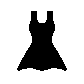

tensor([[0.5720]], grad_fn=<SigmoidBackward>)
tensor([[0.4679]], grad_fn=<SigmoidBackward>)


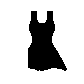

tensor([[0.5928]], grad_fn=<SigmoidBackward>)
tensor([[0.4768]], grad_fn=<SigmoidBackward>)


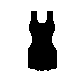

tensor([[0.5880]], grad_fn=<SigmoidBackward>)
tensor([[0.4670]], grad_fn=<SigmoidBackward>)


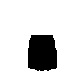

tensor([[0.5893]], grad_fn=<SigmoidBackward>)
tensor([[0.5044]], grad_fn=<SigmoidBackward>)


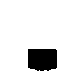

tensor([[0.5521]], grad_fn=<SigmoidBackward>)
tensor([[0.5302]], grad_fn=<SigmoidBackward>)
0 0.5 0.6666666666666666
1 1.0 0.6666666666666666


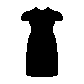

tensor([[0.5919]], grad_fn=<SigmoidBackward>)
tensor([[0.4459]], grad_fn=<SigmoidBackward>)


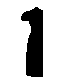

tensor([[0.4600]], grad_fn=<SigmoidBackward>)
tensor([[0.5049]], grad_fn=<SigmoidBackward>)


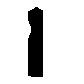

tensor([[0.4727]], grad_fn=<SigmoidBackward>)
tensor([[0.5005]], grad_fn=<SigmoidBackward>)


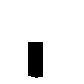

tensor([[0.4819]], grad_fn=<SigmoidBackward>)
tensor([[0.5161]], grad_fn=<SigmoidBackward>)
0 0.5 0.6666666666666666
1 0.5 1.0


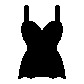

tensor([[0.5681]], grad_fn=<SigmoidBackward>)
tensor([[0.4478]], grad_fn=<SigmoidBackward>)


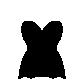

tensor([[0.5759]], grad_fn=<SigmoidBackward>)
tensor([[0.4650]], grad_fn=<SigmoidBackward>)


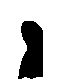

tensor([[0.4103]], grad_fn=<SigmoidBackward>)
tensor([[0.4604]], grad_fn=<SigmoidBackward>)


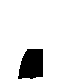

tensor([[0.4619]], grad_fn=<SigmoidBackward>)
tensor([[0.5146]], grad_fn=<SigmoidBackward>)


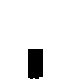

tensor([[0.5086]], grad_fn=<SigmoidBackward>)
tensor([[0.5259]], grad_fn=<SigmoidBackward>)
0 0.0 0.3333333333333333
1 1.0 0.6666666666666666


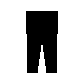

tensor([[0.5517]], grad_fn=<SigmoidBackward>)
tensor([[0.4299]], grad_fn=<SigmoidBackward>)


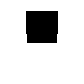

tensor([[0.4779]], grad_fn=<SigmoidBackward>)
tensor([[0.5203]], grad_fn=<SigmoidBackward>)


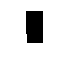

tensor([[0.4766]], grad_fn=<SigmoidBackward>)
tensor([[0.6252]], grad_fn=<SigmoidBackward>)
0 0.5 1.0
1 1.0 1.0


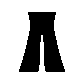

tensor([[0.5400]], grad_fn=<SigmoidBackward>)
tensor([[0.4492]], grad_fn=<SigmoidBackward>)


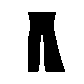

tensor([[0.5688]], grad_fn=<SigmoidBackward>)
tensor([[0.4552]], grad_fn=<SigmoidBackward>)


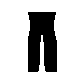

tensor([[0.5451]], grad_fn=<SigmoidBackward>)
tensor([[0.4459]], grad_fn=<SigmoidBackward>)


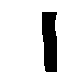

tensor([[0.6599]], grad_fn=<SigmoidBackward>)
tensor([[0.4868]], grad_fn=<SigmoidBackward>)


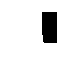

tensor([[0.6227]], grad_fn=<SigmoidBackward>)
tensor([[0.5577]], grad_fn=<SigmoidBackward>)
0 1.0 0.6666666666666666
1 1.0 0.6666666666666666


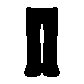

tensor([[0.5807]], grad_fn=<SigmoidBackward>)
tensor([[0.4503]], grad_fn=<SigmoidBackward>)


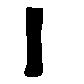

tensor([[0.4604]], grad_fn=<SigmoidBackward>)
tensor([[0.4928]], grad_fn=<SigmoidBackward>)


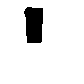

tensor([[0.4512]], grad_fn=<SigmoidBackward>)
tensor([[0.6254]], grad_fn=<SigmoidBackward>)


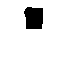

tensor([[0.4792]], grad_fn=<SigmoidBackward>)
tensor([[0.6636]], grad_fn=<SigmoidBackward>)
0 0.5 0.6666666666666666
1 1.0 1.0


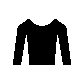

tensor([[0.4987]], grad_fn=<SigmoidBackward>)
tensor([[0.4355]], grad_fn=<SigmoidBackward>)


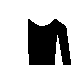

tensor([[0.6188]], grad_fn=<SigmoidBackward>)
tensor([[0.4467]], grad_fn=<SigmoidBackward>)


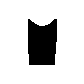

tensor([[0.5576]], grad_fn=<SigmoidBackward>)
tensor([[0.4470]], grad_fn=<SigmoidBackward>)


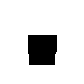

tensor([[0.5872]], grad_fn=<SigmoidBackward>)
tensor([[0.4903]], grad_fn=<SigmoidBackward>)


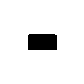

tensor([[0.5488]], grad_fn=<SigmoidBackward>)
tensor([[0.4972]], grad_fn=<SigmoidBackward>)
0 0.5 0.6666666666666666
1 1.0 1.0


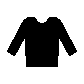

tensor([[0.5420]], grad_fn=<SigmoidBackward>)
tensor([[0.4277]], grad_fn=<SigmoidBackward>)


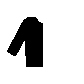

tensor([[0.3970]], grad_fn=<SigmoidBackward>)
tensor([[0.4574]], grad_fn=<SigmoidBackward>)


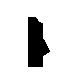

tensor([[0.4666]], grad_fn=<SigmoidBackward>)
tensor([[0.5038]], grad_fn=<SigmoidBackward>)


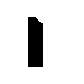

tensor([[0.4352]], grad_fn=<SigmoidBackward>)
tensor([[0.5150]], grad_fn=<SigmoidBackward>)


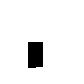

tensor([[0.5105]], grad_fn=<SigmoidBackward>)
tensor([[0.5141]], grad_fn=<SigmoidBackward>)
0 0.5 0.6666666666666666
0 1.0 1.0


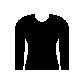

tensor([[0.5210]], grad_fn=<SigmoidBackward>)
tensor([[0.4293]], grad_fn=<SigmoidBackward>)


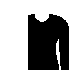

tensor([[0.6232]], grad_fn=<SigmoidBackward>)
tensor([[0.4339]], grad_fn=<SigmoidBackward>)


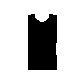

tensor([[0.5641]], grad_fn=<SigmoidBackward>)
tensor([[0.4286]], grad_fn=<SigmoidBackward>)


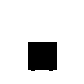

tensor([[0.5561]], grad_fn=<SigmoidBackward>)
tensor([[0.5122]], grad_fn=<SigmoidBackward>)
0 0.5 1.0
1 0.5 0.6666666666666666


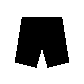

tensor([[0.5147]], grad_fn=<SigmoidBackward>)
tensor([[0.4351]], grad_fn=<SigmoidBackward>)


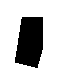

tensor([[0.4062]], grad_fn=<SigmoidBackward>)
tensor([[0.4673]], grad_fn=<SigmoidBackward>)


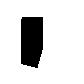

tensor([[0.4108]], grad_fn=<SigmoidBackward>)
tensor([[0.4747]], grad_fn=<SigmoidBackward>)


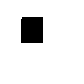

tensor([[0.5194]], grad_fn=<SigmoidBackward>)
tensor([[0.6167]], grad_fn=<SigmoidBackward>)
1 0.5 0.6666666666666666
1 1.0 1.0


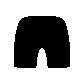

tensor([[0.5032]], grad_fn=<SigmoidBackward>)
tensor([[0.4288]], grad_fn=<SigmoidBackward>)


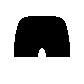

tensor([[0.4644]], grad_fn=<SigmoidBackward>)
tensor([[0.4165]], grad_fn=<SigmoidBackward>)


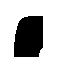

tensor([[0.4146]], grad_fn=<SigmoidBackward>)
tensor([[0.5164]], grad_fn=<SigmoidBackward>)


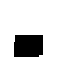

tensor([[0.5097]], grad_fn=<SigmoidBackward>)
tensor([[0.4729]], grad_fn=<SigmoidBackward>)
1 0.5 0.6666666666666666
0 1.0 0.6666666666666666


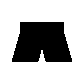

tensor([[0.5146]], grad_fn=<SigmoidBackward>)
tensor([[0.4360]], grad_fn=<SigmoidBackward>)


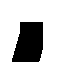

tensor([[0.3979]], grad_fn=<SigmoidBackward>)
tensor([[0.4508]], grad_fn=<SigmoidBackward>)


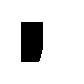

tensor([[0.4118]], grad_fn=<SigmoidBackward>)
tensor([[0.4756]], grad_fn=<SigmoidBackward>)


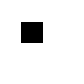

tensor([[0.5194]], grad_fn=<SigmoidBackward>)
tensor([[0.6167]], grad_fn=<SigmoidBackward>)
1 0.5 0.6666666666666666
1 1.0 1.0


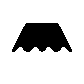

tensor([[0.4889]], grad_fn=<SigmoidBackward>)
tensor([[0.4404]], grad_fn=<SigmoidBackward>)


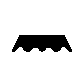

tensor([[0.5072]], grad_fn=<SigmoidBackward>)
tensor([[0.4674]], grad_fn=<SigmoidBackward>)


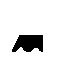

tensor([[0.5579]], grad_fn=<SigmoidBackward>)
tensor([[0.5067]], grad_fn=<SigmoidBackward>)


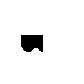

tensor([[0.5649]], grad_fn=<SigmoidBackward>)
tensor([[0.5097]], grad_fn=<SigmoidBackward>)


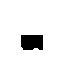

tensor([[0.5649]], grad_fn=<SigmoidBackward>)
tensor([[0.5097]], grad_fn=<SigmoidBackward>)
1 1.0 1.0
1 1.0 1.0


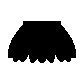

tensor([[0.5240]], grad_fn=<SigmoidBackward>)
tensor([[0.4323]], grad_fn=<SigmoidBackward>)


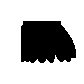

tensor([[0.5543]], grad_fn=<SigmoidBackward>)
tensor([[0.4462]], grad_fn=<SigmoidBackward>)


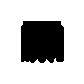

tensor([[0.5314]], grad_fn=<SigmoidBackward>)
tensor([[0.4361]], grad_fn=<SigmoidBackward>)


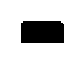

tensor([[0.4590]], grad_fn=<SigmoidBackward>)
tensor([[0.4503]], grad_fn=<SigmoidBackward>)


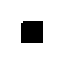

tensor([[0.5195]], grad_fn=<SigmoidBackward>)
tensor([[0.6146]], grad_fn=<SigmoidBackward>)
0 0.0 0.3333333333333333
1 1.0 0.6666666666666666


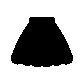

tensor([[0.5499]], grad_fn=<SigmoidBackward>)
tensor([[0.4473]], grad_fn=<SigmoidBackward>)


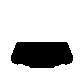

tensor([[0.5556]], grad_fn=<SigmoidBackward>)
tensor([[0.4983]], grad_fn=<SigmoidBackward>)


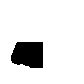

tensor([[0.4212]], grad_fn=<SigmoidBackward>)
tensor([[0.4511]], grad_fn=<SigmoidBackward>)


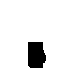

tensor([[0.5151]], grad_fn=<SigmoidBackward>)
tensor([[0.5184]], grad_fn=<SigmoidBackward>)


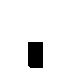

tensor([[0.5094]], grad_fn=<SigmoidBackward>)
tensor([[0.5143]], grad_fn=<SigmoidBackward>)
0 0.0 0.3333333333333333
0 1.0 0.6666666666666666


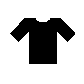

tensor([[0.6023]], grad_fn=<SigmoidBackward>)
tensor([[0.4199]], grad_fn=<SigmoidBackward>)


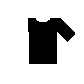

tensor([[0.6569]], grad_fn=<SigmoidBackward>)
tensor([[0.4293]], grad_fn=<SigmoidBackward>)


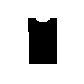

tensor([[0.5990]], grad_fn=<SigmoidBackward>)
tensor([[0.4445]], grad_fn=<SigmoidBackward>)


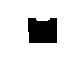

tensor([[0.5165]], grad_fn=<SigmoidBackward>)
tensor([[0.5319]], grad_fn=<SigmoidBackward>)


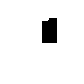

tensor([[0.6522]], grad_fn=<SigmoidBackward>)
tensor([[0.5651]], grad_fn=<SigmoidBackward>)
0 0.5 0.3333333333333333
1 1.0 1.0


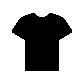

tensor([[0.5680]], grad_fn=<SigmoidBackward>)
tensor([[0.4225]], grad_fn=<SigmoidBackward>)


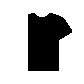

tensor([[0.6206]], grad_fn=<SigmoidBackward>)
tensor([[0.4283]], grad_fn=<SigmoidBackward>)


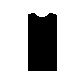

tensor([[0.5787]], grad_fn=<SigmoidBackward>)
tensor([[0.4347]], grad_fn=<SigmoidBackward>)


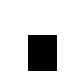

tensor([[0.5915]], grad_fn=<SigmoidBackward>)
tensor([[0.5007]], grad_fn=<SigmoidBackward>)


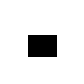

tensor([[0.5454]], grad_fn=<SigmoidBackward>)
tensor([[0.4873]], grad_fn=<SigmoidBackward>)
0 0.5 0.6666666666666666
0 1.0 1.0


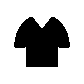

tensor([[0.5469]], grad_fn=<SigmoidBackward>)
tensor([[0.4385]], grad_fn=<SigmoidBackward>)


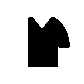

tensor([[0.6125]], grad_fn=<SigmoidBackward>)
tensor([[0.4451]], grad_fn=<SigmoidBackward>)


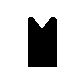

tensor([[0.5514]], grad_fn=<SigmoidBackward>)
tensor([[0.4423]], grad_fn=<SigmoidBackward>)


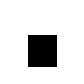

tensor([[0.5699]], grad_fn=<SigmoidBackward>)
tensor([[0.4898]], grad_fn=<SigmoidBackward>)


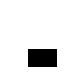

tensor([[0.5421]], grad_fn=<SigmoidBackward>)
tensor([[0.5273]], grad_fn=<SigmoidBackward>)
0 0.5 0.6666666666666666
1 1.0 0.6666666666666666


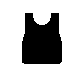

tensor([[0.5231]], grad_fn=<SigmoidBackward>)
tensor([[0.4222]], grad_fn=<SigmoidBackward>)


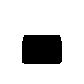

tensor([[0.5438]], grad_fn=<SigmoidBackward>)
tensor([[0.4833]], grad_fn=<SigmoidBackward>)


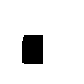

tensor([[0.4594]], grad_fn=<SigmoidBackward>)
tensor([[0.4724]], grad_fn=<SigmoidBackward>)
0 0.5 1.0
0 1.0 1.0


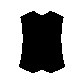

tensor([[0.5509]], grad_fn=<SigmoidBackward>)
tensor([[0.4247]], grad_fn=<SigmoidBackward>)


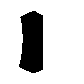

tensor([[0.4043]], grad_fn=<SigmoidBackward>)
tensor([[0.4694]], grad_fn=<SigmoidBackward>)


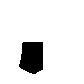

tensor([[0.4487]], grad_fn=<SigmoidBackward>)
tensor([[0.4798]], grad_fn=<SigmoidBackward>)


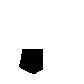

tensor([[0.4805]], grad_fn=<SigmoidBackward>)
tensor([[0.4983]], grad_fn=<SigmoidBackward>)
0 0.5 0.6666666666666666
1 1.0 1.0


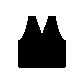

tensor([[0.5342]], grad_fn=<SigmoidBackward>)
tensor([[0.4440]], grad_fn=<SigmoidBackward>)


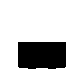

tensor([[0.5390]], grad_fn=<SigmoidBackward>)
tensor([[0.5065]], grad_fn=<SigmoidBackward>)


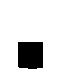

tensor([[0.4596]], grad_fn=<SigmoidBackward>)
tensor([[0.4785]], grad_fn=<SigmoidBackward>)


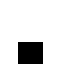

tensor([[0.4763]], grad_fn=<SigmoidBackward>)
tensor([[0.4829]], grad_fn=<SigmoidBackward>)
0 0.0 0.6666666666666666
0 0.5 1.0


In [49]:
index = 0

for index in range(len(ci.image_list)):

    m1_score_list = []
    m2_score_list = []

    for j in range(len(ci.image_list[index])):
        cloth_img = read_cloth_image(ci.image_list[index][j])
        m1_score = calculate_image_score(cloth_img, transforms_test, model)
        m1_score_list.append(m1_score.item())
        print(m1_score)

        m2_score = calculate_image_score(cloth_img, transforms_test, model2)
        m2_score_list.append(m2_score.item())
        print(m2_score)

    m1_score_list_sorted_index = sorted(range(len(m1_score_list)), key=lambda k: m1_score_list[k])

    p_at_1 = int(m1_score_list_sorted_index[-1] == len(m1_score_list_sorted_index) - 1)

    p_at_2 = (len(m1_score_list_sorted_index) - 1 in m1_score_list_sorted_index[-2:]) + (len(m1_score_list_sorted_index) - 2 in m1_score_list_sorted_index[-2:])

    p_at_2 = p_at_2 / 2.0

    p_at_3 = (len(m1_score_list_sorted_index) - 1 in m1_score_list_sorted_index[-3:]) + \
    (len(m1_score_list_sorted_index) - 2 in m1_score_list_sorted_index[-3:]) + \
    (len(m1_score_list_sorted_index) - 3 in m1_score_list_sorted_index[-3:])

    p_at_3 = p_at_3 / 3.0

    print(p_at_1, p_at_2, p_at_3)

    m2_score_list_sorted_index = sorted(range(len(m2_score_list)), key=lambda k: m2_score_list[k])

    p2_at_1 = int(m2_score_list_sorted_index[-1] == len(m2_score_list_sorted_index) - 1)

    p2_at_2 = (len(m2_score_list_sorted_index) - 1 in m2_score_list_sorted_index[-2:]) + (len(m2_score_list_sorted_index) - 2 in m2_score_list_sorted_index[-2:])

    p2_at_2 = p2_at_2 / 2.0

    p2_at_3 = (len(m2_score_list_sorted_index) - 1 in m2_score_list_sorted_index[-3:]) + \
    (len(m2_score_list_sorted_index) - 2 in m2_score_list_sorted_index[-3:]) + \
    (len(m2_score_list_sorted_index) - 3 in m2_score_list_sorted_index[-3:])

    p2_at_3 = p2_at_3 / 3.0

    print(p2_at_1, p2_at_2, p2_at_3)

    precision_list.append([p_at_1, p_at_2, p_at_3,p2_at_1, p2_at_2, p2_at_3])


In [50]:
precision_list

[[0, 0.5, 0.6666666666666666, 1, 1.0, 0.6666666666666666],
 [0, 0.5, 0.6666666666666666, 1, 0.5, 1.0],
 [0, 0.0, 0.3333333333333333, 1, 1.0, 0.6666666666666666],
 [0, 0.5, 1.0, 1, 1.0, 1.0],
 [0, 1.0, 0.6666666666666666, 1, 1.0, 0.6666666666666666],
 [0, 0.5, 0.6666666666666666, 1, 1.0, 1.0],
 [0, 0.5, 0.6666666666666666, 1, 1.0, 1.0],
 [0, 0.5, 0.6666666666666666, 0, 1.0, 1.0],
 [0, 0.5, 1.0, 1, 0.5, 0.6666666666666666],
 [1, 0.5, 0.6666666666666666, 1, 1.0, 1.0],
 [1, 0.5, 0.6666666666666666, 0, 1.0, 0.6666666666666666],
 [1, 0.5, 0.6666666666666666, 1, 1.0, 1.0],
 [1, 1.0, 1.0, 1, 1.0, 1.0],
 [0, 0.0, 0.3333333333333333, 1, 1.0, 0.6666666666666666],
 [0, 0.0, 0.3333333333333333, 0, 1.0, 0.6666666666666666],
 [0, 0.5, 0.3333333333333333, 1, 1.0, 1.0],
 [0, 0.5, 0.6666666666666666, 0, 1.0, 1.0],
 [0, 0.5, 0.6666666666666666, 1, 1.0, 0.6666666666666666],
 [0, 0.5, 1.0, 0, 1.0, 1.0],
 [0, 0.5, 0.6666666666666666, 1, 1.0, 1.0],
 [0, 0.0, 0.6666666666666666, 0, 0.5, 1.0]]

In [34]:
precision_list = []

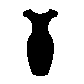

tensor([[0.4484]], grad_fn=<SigmoidBackward>)
tensor([[0.4419]], grad_fn=<SigmoidBackward>)


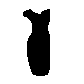

tensor([[0.4357]], grad_fn=<SigmoidBackward>)
tensor([[0.4484]], grad_fn=<SigmoidBackward>)


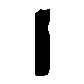

tensor([[0.4080]], grad_fn=<SigmoidBackward>)
tensor([[0.4198]], grad_fn=<SigmoidBackward>)


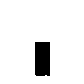

tensor([[0.4265]], grad_fn=<SigmoidBackward>)
tensor([[0.3756]], grad_fn=<SigmoidBackward>)


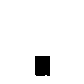

tensor([[0.5162]], grad_fn=<SigmoidBackward>)
tensor([[0.4320]], grad_fn=<SigmoidBackward>)
1 0.5 0.3333333333333333
0 0.0 0.3333333333333333


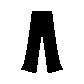

tensor([[0.4980]], grad_fn=<SigmoidBackward>)
tensor([[0.4385]], grad_fn=<SigmoidBackward>)


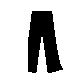

tensor([[0.5238]], grad_fn=<SigmoidBackward>)
tensor([[0.4429]], grad_fn=<SigmoidBackward>)


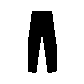

tensor([[0.4886]], grad_fn=<SigmoidBackward>)
tensor([[0.4434]], grad_fn=<SigmoidBackward>)


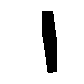

tensor([[0.5193]], grad_fn=<SigmoidBackward>)
tensor([[0.4173]], grad_fn=<SigmoidBackward>)


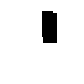

tensor([[0.5027]], grad_fn=<SigmoidBackward>)
tensor([[0.4588]], grad_fn=<SigmoidBackward>)


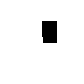

tensor([[0.5250]], grad_fn=<SigmoidBackward>)
tensor([[0.5062]], grad_fn=<SigmoidBackward>)
1 0.5 0.6666666666666666
1 1.0 0.6666666666666666


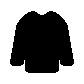

tensor([[0.5422]], grad_fn=<SigmoidBackward>)
tensor([[0.3983]], grad_fn=<SigmoidBackward>)


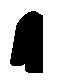

tensor([[0.5037]], grad_fn=<SigmoidBackward>)
tensor([[0.3846]], grad_fn=<SigmoidBackward>)


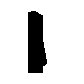

tensor([[0.4951]], grad_fn=<SigmoidBackward>)
tensor([[0.4345]], grad_fn=<SigmoidBackward>)


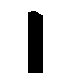

tensor([[0.4969]], grad_fn=<SigmoidBackward>)
tensor([[0.4242]], grad_fn=<SigmoidBackward>)


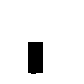

tensor([[0.4786]], grad_fn=<SigmoidBackward>)
tensor([[0.3846]], grad_fn=<SigmoidBackward>)


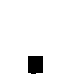

tensor([[0.5422]], grad_fn=<SigmoidBackward>)
tensor([[0.4540]], grad_fn=<SigmoidBackward>)
1 0.5 0.3333333333333333
1 0.5 0.6666666666666666


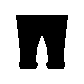

tensor([[0.5211]], grad_fn=<SigmoidBackward>)
tensor([[0.4141]], grad_fn=<SigmoidBackward>)


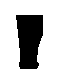

tensor([[0.4859]], grad_fn=<SigmoidBackward>)
tensor([[0.4220]], grad_fn=<SigmoidBackward>)


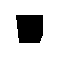

tensor([[0.5249]], grad_fn=<SigmoidBackward>)
tensor([[0.4742]], grad_fn=<SigmoidBackward>)


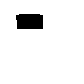

tensor([[0.5184]], grad_fn=<SigmoidBackward>)
tensor([[0.5278]], grad_fn=<SigmoidBackward>)
0 0.5 0.6666666666666666
1 1.0 1.0


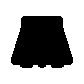

tensor([[0.4314]], grad_fn=<SigmoidBackward>)
tensor([[0.3824]], grad_fn=<SigmoidBackward>)


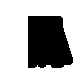

tensor([[0.5033]], grad_fn=<SigmoidBackward>)
tensor([[0.3676]], grad_fn=<SigmoidBackward>)


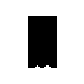

tensor([[0.4247]], grad_fn=<SigmoidBackward>)
tensor([[0.4092]], grad_fn=<SigmoidBackward>)


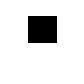

tensor([[0.5283]], grad_fn=<SigmoidBackward>)
tensor([[0.4759]], grad_fn=<SigmoidBackward>)


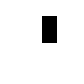

tensor([[0.5454]], grad_fn=<SigmoidBackward>)
tensor([[0.4846]], grad_fn=<SigmoidBackward>)
1 1.0 0.6666666666666666
1 1.0 1.0


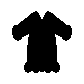

tensor([[0.5027]], grad_fn=<SigmoidBackward>)
tensor([[0.4240]], grad_fn=<SigmoidBackward>)


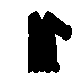

tensor([[0.5009]], grad_fn=<SigmoidBackward>)
tensor([[0.4144]], grad_fn=<SigmoidBackward>)


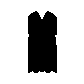

tensor([[0.4888]], grad_fn=<SigmoidBackward>)
tensor([[0.4295]], grad_fn=<SigmoidBackward>)


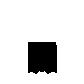

tensor([[0.5389]], grad_fn=<SigmoidBackward>)
tensor([[0.3646]], grad_fn=<SigmoidBackward>)


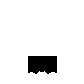

tensor([[0.5037]], grad_fn=<SigmoidBackward>)
tensor([[0.4693]], grad_fn=<SigmoidBackward>)
0 1.0 0.6666666666666666
1 0.5 0.6666666666666666


In [35]:
index = 0

for index in range(len(ci_test.image_list)):

    m1_score_list = []
    m2_score_list = []

    for j in range(len(ci_test.image_list[index])):
        cloth_img = read_cloth_image(ci_test.image_list[index][j])
        m1_score = calculate_image_score(cloth_img, transforms_test, model)
        m1_score_list.append(m1_score.item())
        print(m1_score)

        m2_score = calculate_image_score(cloth_img, transforms_test, model2)
        m2_score_list.append(m2_score.item())
        print(m2_score)

    m1_score_list_sorted_index = sorted(range(len(m1_score_list)), key=lambda k: m1_score_list[k])

    p_at_1 = int(m1_score_list_sorted_index[-1] == len(m1_score_list_sorted_index) - 1)

    p_at_2 = (len(m1_score_list_sorted_index) - 1 in m1_score_list_sorted_index[-2:]) + (len(m1_score_list_sorted_index) - 2 in m1_score_list_sorted_index[-2:])

    p_at_2 = p_at_2 / 2.0

    p_at_3 = (len(m1_score_list_sorted_index) - 1 in m1_score_list_sorted_index[-3:]) + \
    (len(m1_score_list_sorted_index) - 2 in m1_score_list_sorted_index[-3:]) + \
    (len(m1_score_list_sorted_index) - 3 in m1_score_list_sorted_index[-3:])

    p_at_3 = p_at_3 / 3.0

    print(p_at_1, p_at_2, p_at_3)

    m2_score_list_sorted_index = sorted(range(len(m2_score_list)), key=lambda k: m2_score_list[k])

    p2_at_1 = int(m2_score_list_sorted_index[-1] == len(m2_score_list_sorted_index) - 1)

    p2_at_2 = (len(m2_score_list_sorted_index) - 1 in m2_score_list_sorted_index[-2:]) + (len(m2_score_list_sorted_index) - 2 in m2_score_list_sorted_index[-2:])

    p2_at_2 = p2_at_2 / 2.0

    p2_at_3 = (len(m2_score_list_sorted_index) - 1 in m2_score_list_sorted_index[-3:]) + \
    (len(m2_score_list_sorted_index) - 2 in m2_score_list_sorted_index[-3:]) + \
    (len(m2_score_list_sorted_index) - 3 in m2_score_list_sorted_index[-3:])

    p2_at_3 = p2_at_3 / 3.0

    print(p2_at_1, p2_at_2, p2_at_3)

    precision_list.append([p_at_1, p_at_2, p_at_3,p2_at_1, p2_at_2, p2_at_3])


In [36]:
precision_list

[[1, 0.5, 0.3333333333333333, 0, 0.0, 0.3333333333333333],
 [1, 0.5, 0.6666666666666666, 1, 1.0, 0.6666666666666666],
 [1, 0.5, 0.3333333333333333, 1, 0.5, 0.6666666666666666],
 [0, 0.5, 0.6666666666666666, 1, 1.0, 1.0],
 [1, 1.0, 0.6666666666666666, 1, 1.0, 1.0],
 [0, 1.0, 0.6666666666666666, 1, 0.5, 0.6666666666666666]]